# Examen Final - Nivelación en Bases de Datos Relacionales
**Alumna:** Natalia Chavez  
**Fecha:** 22 de Febrero, 2026  

## Parte A: Bases de Datos Relacionales

### Consigna
Construir una consulta SQL que permita agrupar en un único registro los datos de un alumno con todas sus calificaciones:
- IdAlumno, EdadAlIngreso, Sexo, Egresado
- Asignatura1, MesesDesdeIngreso1, Calificación1
- ... (hasta Asignatura4)

Quedándose con la **máxima calificación** si la hubiera rendido varias veces.

**Contexto**: El dataset original (fecha de creación 26/08/2020 según metadatos) presentaba estructura desnormalizada, con asignaturas y calificaciones en formato horizontal (Asignatura1, Asignatura2, etc.).
Esto dificultaba análisis longitudinal y consultas escalables.

**Decisiones de diseño:**
- Normalización a 3FN para eliminar redundancias.
- Tabla `Género` separada para soportar identidades no binarias.
- Tabla `Tipo_de_examen` para diferenciar parciales, finales y recuperatorios.
- Relación N:M entre `Asignatura` y `Plan_Estudio` mediante `Asignatura_Plan` para escalabilidad.

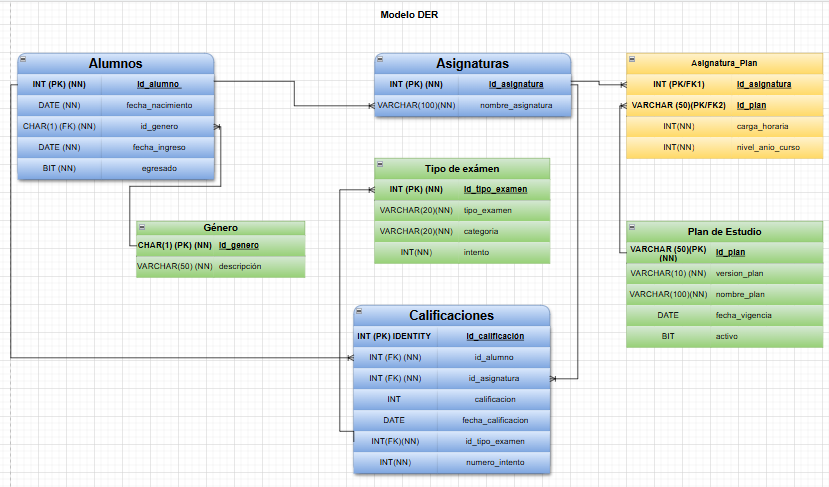



### **Script SQL**

**-- 1. CREACIÓN DE TABLAS MAESTRAS (NORMALIZACIÓN)**

CREATE TABLE Generos (
    IdGenero INT PRIMARY KEY,
    Descripcion VARCHAR(20)
);

CREATE TABLE Planes (
    IdPlan INT PRIMARY KEY,
    NombrePlan VARCHAR(50),
    AñoLanzamiento INT
);

**-- 2. TABLA ALUMNOS (CON LÓGICA DE FECHAS CORREGIDA)**

CREATE TABLE Alumnos (
    IdAlumno INT PRIMARY KEY,
    Nombre VARCHAR(100),
    IdGenero INT,
    FechaNacimiento DATE, -- Calculada según auditoría PDF 2020
    FechaIngreso DATE,
    IdPlan INT,
    FOREIGN KEY (IdGenero) REFERENCES Generos(IdGenero),
    FOREIGN KEY (IdPlan) REFERENCES Planes(IdPlan)
);

**-- 3. TABLA ASIGNATURAS Y RELACIÓN CON PLANES**

CREATE TABLE Asignaturas (
    IdAsignatura INT PRIMARY KEY,
    NombreMateria VARCHAR(100)
);

CREATE TABLE Plan_Asignaturas (
    IdPlan INT,
    IdAsignatura INT,
    Cuatrimestre INT,
    PRIMARY KEY (IdPlan, IdAsignatura),
    FOREIGN KEY (IdPlan) REFERENCES Planes(IdPlan),
    FOREIGN KEY (IdAsignatura) REFERENCES Asignaturas(IdAsignatura)
);

**-- 4. TABLA DE TRANSACCIONES (CALIFICACIONES)**

CREATE TABLE Calificaciones (
    IdCalificacion INT PRIMARY KEY AUTO_INCREMENT,
    IdAlumno INT,
    IdAsignatura INT,
    Nota DECIMAL(4,2),
    FechaCalificacion DATE,
    FOREIGN KEY (IdAlumno) REFERENCES Alumnos(IdAlumno),
    FOREIGN KEY (IdAsignatura) REFERENCES Asignaturas(IdAsignatura)
);

**-- 5. INSERCIÓN DE DATOS SEMILLA**

INSERT INTO Generos VALUES (1, 'Femenino'), (2, 'Masculino');
INSERT INTO Planes VALUES (1, 'Plan Analista 2018', 2018);

**-- Ajuste de 2020 detectado en metadatos de archivo de dataset original**

INSERT INTO Alumnos VALUES
(1, 'Alumno 1', 1, '1985-05-15', '2008-03-01', 1), -- Edad ingreso: 23 años
(2, 'Alumno 2', 2, '2000-11-20', '2020-03-01', 1); -- Edad ingreso: 20 años

INSERT INTO Asignaturas VALUES
(1, 'Análisis Matemático I'), (2, 'Programación I'),
(3, 'Bases de Datos I'), (4, 'Electrónica');





**## QUERY DE PIVOTEO**


-- CONSULTA DE TRANSFORMACIÓN: DATASET ANALÍTICO FINAL
-- Objetivo: Pivotear las materias y calcular tiempos de permanencia. *texto en cursiva*


SELECT

    A.IdAlumno,
    DATEDIFF(YEAR, A.FechaNacimiento, A.FechaIngreso) AS EdadAlIngreso,
    G.Descripcion AS Sexo, Egresado
    
    
    -- Materia 1: Análisis Matemático I
    'Análisis Matemático I' AS Asignatura1,
    MAX(CASE WHEN ASIG.NombreMateria = 'Análisis Matemático I'
             THEN DATEDIFF(MONTH, A.FechaIngreso, C.FechaCalificacion) END) AS MesesDesdeIngreso1,
    MAX(CASE WHEN ASIG.NombreMateria = 'Análisis Matemático I'
             THEN C.Nota END) AS Calificacion1,

    -- Materia 2: Programación I
    'Programación I' AS Asignatura2,
    MAX(CASE WHEN ASIG.NombreMateria = 'Programación I'
             THEN DATEDIFF(MONTH, A.FechaIngreso, C.FechaCalificacion) END) AS MesesDesdeIngreso2,
    MAX(CASE WHEN ASIG.NombreMateria = 'Programación I'
             THEN C.Nota END) AS Calificacion2,

    -- Materia 3: Bases de Datos I
    'Bases de Datos I' AS Asignatura3,
    MAX(CASE WHEN ASIG.NombreMateria = 'Bases de Datos I'
             THEN DATEDIFF(MONTH, A.FechaIngreso, C.FechaCalificacion) END) AS MesesDesdeIngreso3,
    MAX(CASE WHEN ASIG.NombreMateria = 'Bases de Datos I'
             THEN C.Nota END) AS Calificacion3,

    -- Materia 4: Electrónica (Se mantiene para mostrar manejo de NULLs)
    'Electrónica' AS Asignatura4,
    MAX(CASE WHEN ASIG.NombreMateria = 'Electrónica'
             THEN DATEDIFF(MONTH, A.FechaIngreso, C.FechaCalificacion) END) AS MesesDesdeIngreso4,
    MAX(CASE WHEN ASIG.NombreMateria = 'Electrónica'
             THEN C.Nota END) AS Calificacion4

FROM Alumnos A

INNER JOIN Generos G ON A.IdGenero = G.IdGenero

LEFT JOIN Calificaciones C ON A.IdAlumno = C.IdAlumno

LEFT JOIN Asignaturas ASIG ON C.IdAsignatura = ASIG.IdAsignatura

GROUP BY A.IdAlumno, A.FechaNacimiento, A.FechaIngreso, G.Descripcion

ORDER BY A.IdAlumno;



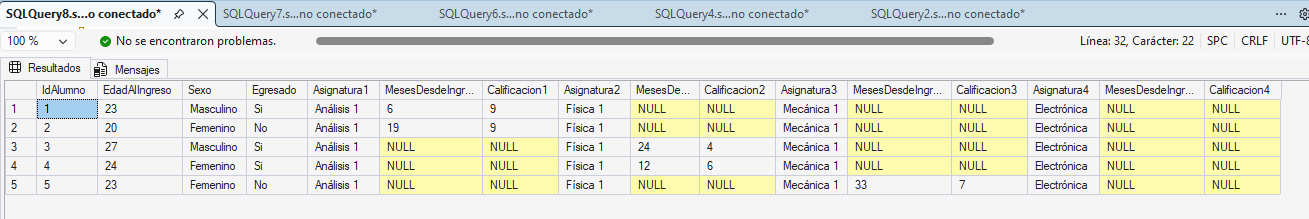

## Parte B: Programación Lógica

### Consigna B

Un barco portacontenedores acomoda en su cubierta 10 contenedores de ancho por 20 de largo y 5 de altura. Cada contenedor mide 2 m de ancho, 2 m de alto y 5 m de longitud. Se pide verificar el equilibrio del barco. Para eso hay que recorrer los contenedores sumando el peso del contenedor multiplicado por su coordenada x respecto del centro del barco en una variable Mx y su peso multiplicado por su coordenada y respecto del centro del barco.

**PSEUDOCODIGO **

Algoritmo: Verificar_Equilibrio_Barco
Ciclo controlado por cantidad de datos "mientras haya filas"

INICIO
    // Inicialización
    Mx ← 0
    My ← 0
    contador ← 1
   CantidadContenedores  ←    20*10*5
ToleranciaX ← 75*10*(LargoBarcoX/2) ToleranciaX ← 75*10*(LargoXBarco/2)
ToleranciaY ← 75*10*(LargoBarcoY/2)

    // Abrir archivo
    archivo ← AbrirCSV("contenedores.csv")

    // Procesar cada fila
    MIENTRAS HayFilas(archivo) HACER
        fila ← LeerFila(archivo)
        peso ← fila.peso
        x ← fila.coord_x
        y ← fila.coord_y

        // Validar datos
        SI peso > 0 Y x ≠ NULO Y y ≠ NULO ENTONCES
            Mx ← Mx + (peso × x)
            My ← My + (peso × y)
            contador ← contador + 1
        FIN_SI
    FIN_MIENTRAS

    // Cerrar archivo
    CerrarCSV(archivo)

    // Verificar equilibrio
    SI |Mx| < tolerancia Y |My| < tolerancia ENTONCES
        IMPRIMIR "Barco equilibrado"
        IMPRIMIR "Mx =", Mx, "ton*m"
        IMPRIMIR "My =", My, "ton*m"
    SINO
        IMPRIMIR "Barco desequilibrado"
        IMPRIMIR "Mx =", Mx, "ton*m (límite: ±", tolerancia, ")"
        IMPRIMIR "My =", My, "ton*m (límite: ±", tolerancia, ")"
    FIN_SI
FIN

**Diseño Jerárquico por Refinamiento Sucesivo**

NIVEL 0

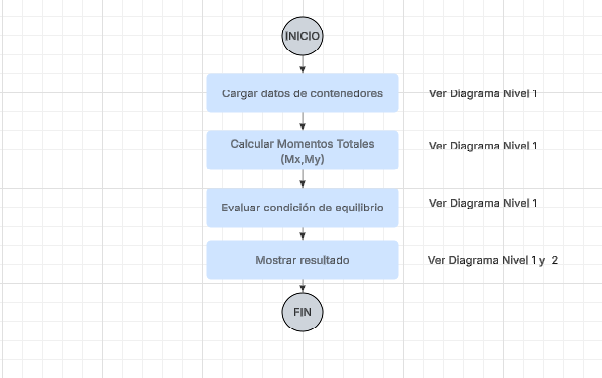

NIVEL 1

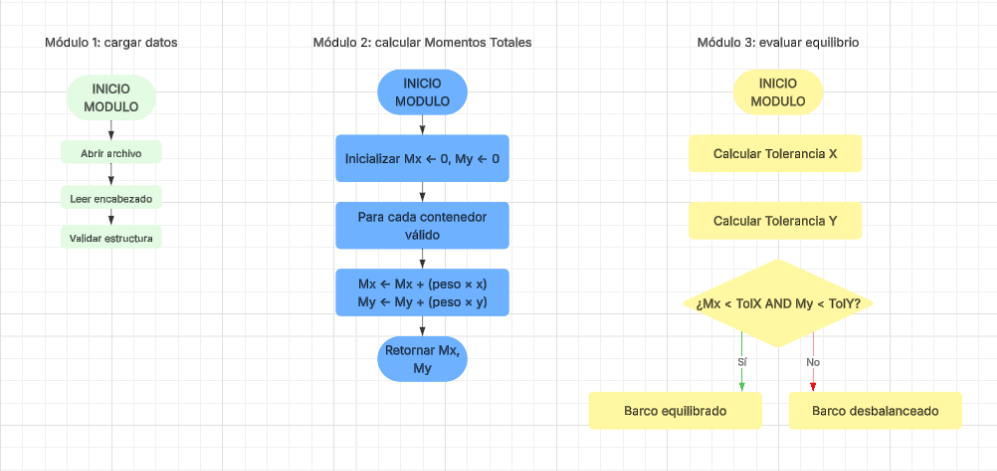

NIVEL 2

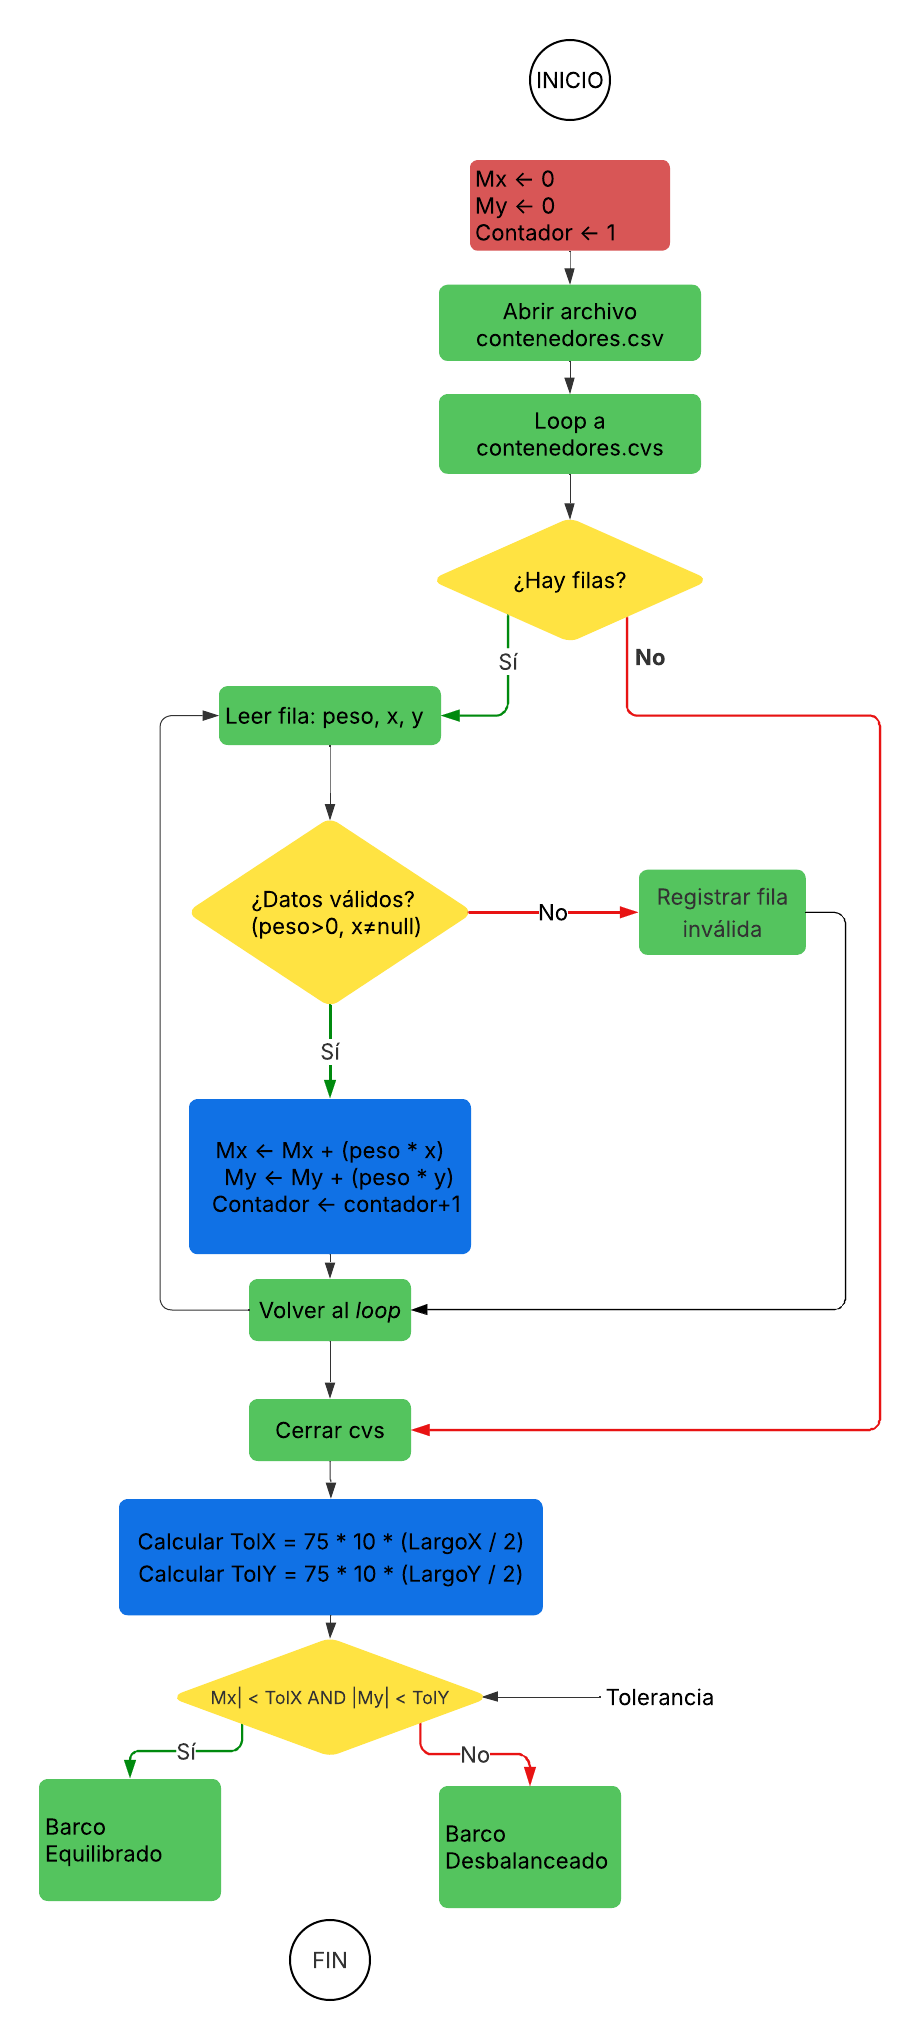

In [ ]:
import pandas as pd

# ---------------------------------------------------------
# MÓDULO 1 (Nivel 1): Inicialización y Carga de Datos
# ---------------------------------------------------------
Mx = 0
My = 0
contador = 1
CantidadContenedores = 20*10*5
ToleranciaX = 75*10*(20/2)
ToleranciaY = 75*10*(100/2)
archivo = pd.read_csv("contenedores.csv", sep=";") #Para resolver el error en mi archivo que no me guardó Delimitado por comas#

# ---------------------------------------------------------
# MÓDULO 2 (Nivel 1): Procesamiento y Cálculo de Momentos
# ---------------------------------------------------------
for index, fila in archivo.iterrows():
    peso = fila["peso"]
    x = fila["x"]
    y = fila["y"]

    if peso > 0 and pd.notna(x) and pd.notna(y):
        Mx = Mx + (peso * x)
        My = My + (peso * y)
        contador = contador + 1

# ---------------------------------------------------------
# MÓDULO 3 (Nivel 1): Evaluación de Estado y Salida
# ---------------------------------------------------------
if abs(Mx) < ToleranciaX and abs(My) < ToleranciaY:
    print("Barco equilibrado")
else:
    print("Barco desequilibrado")

Barco equilibrado


In [ ]:
print(archivo.columns)

Index(['contenedor', 'peso', 'x', 'y'], dtype='object')


In [ ]:
print(archivo.head())

   contenedor  peso     x    y
0           1    20  10.0  5.0
1           2    20 -10.0 -5.0
2           3    30   0.0  0.0
3           4    15   NaN  8.0
4           5    25   4.0  NaN


**
## Parte D: Estadística

### Consigna:

El promedio de los contenedores pesa 19.8 toneladas.
El desvío estándar es de 3 toneladas. Asuma que la distribución de probabilidades de los contenedores en una gaussiana.

1. Calcule la probabilidad de encontrar un contenedor de 30 Toneladas o más.

2. Los contenedores de tres barcos se descargan en puerto en tres grupos separados. Seleccionamos tres contenedores al azar de cada grupo. Obtenemos tres contendores de 30 Toneladas. Resulta esto compatible con un nivel de confianza del del 90% que los contenedores vengan del barco cuyo contenedor promedio pesaba 19.8 toneladas con un desvío estándar de 3 toneladas.

**Hipótesis nula (H0)**: Los contenedores vienen del barco con media 19.8 y desvío 3.

**Resultado observado**: tres contenedores de 30 toneladas.

**Probabilidad de que eso ocurra si H0 es verdadera**: 0.000000000038.


**Modus tollens:**

Si H0 es verdadera → P(tres contenedores de 30t) = 0.000000000038

P(tres contenedores de 30t) = 0.000000000038 es prácticamente imposible

Por lo tanto → H0 es probablemente falsa


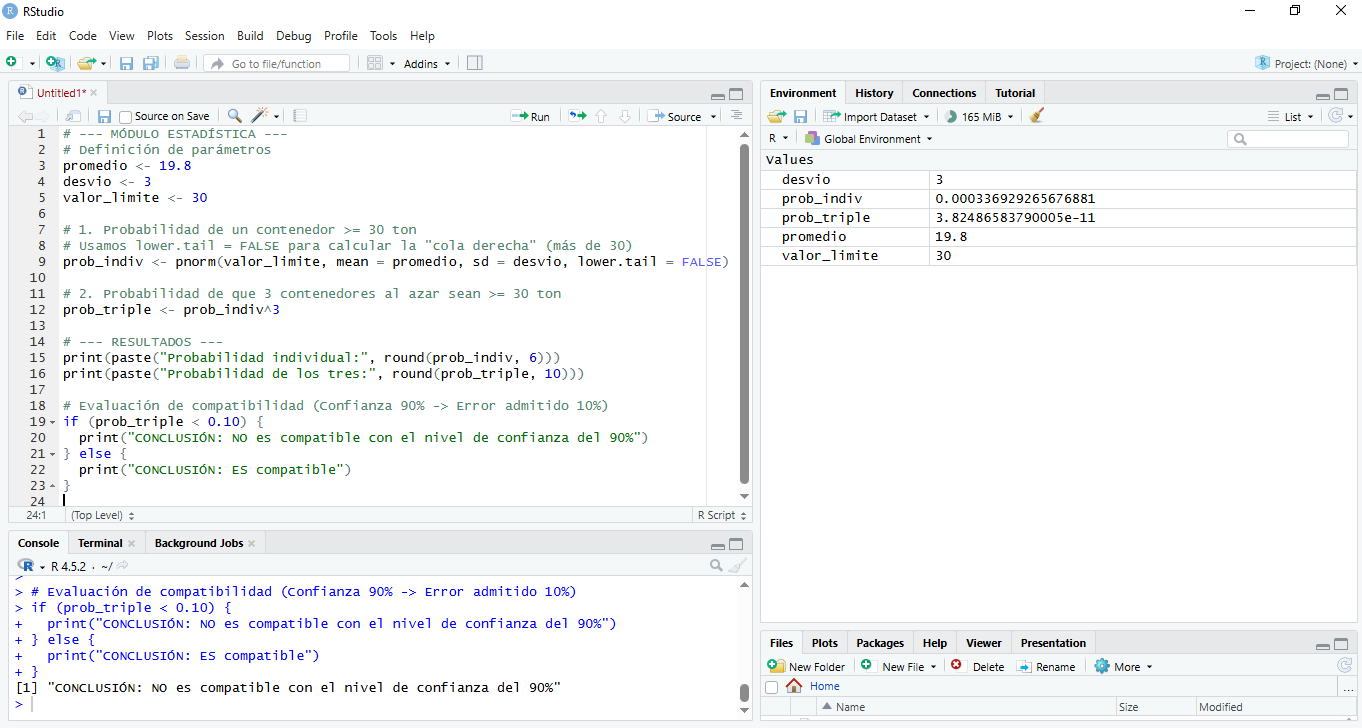